In [20]:
# default_exp vector_models_test
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Creating the Vector Models for the Whole Alphabet

> Creating the `VectorRenderLayer` models for the whole (with some possible exceptions) uppercase sans-serif alphabet. The parameters are based on the list [Sans-serif uppercase font parameters](https://docs.google.com/spreadsheets/d/1myiVDPCNNRzwTSw9VFKqdw26Bk8wPQNQXa9ix_EL_CA/edit?usp=sharing).

In [21]:
#export
from aifont.core import *
from aifont.fontlearner import *
from aifont.ocrlearner import *
from collections import OrderedDict
from enum import Enum, auto
from fastai.data.all import *
from fastai.vision.all import *
import gc
from nbdev.showdoc import *
from pandas import DataFrame
import pydiffvg
import torch
from typing import Callable, List, Protocol, Tuple, Union

## To Do

* Gradient clipping so we can use a large enough LR to capture the small local variations in loss
  * See https://docs.fast.ai/callback.training.html#GradientClip
* Test thickness
* Fix learner shadow attribute
* Convert weights to relative weigths based on a master value

## Letter Model

### Constants and utilities

In [22]:
#export

DEFAULT_FONT_PARAM_SPECS = OrderedDict({
    "Height": PRANGE_NONZERO,
    "Slant": PRANGE_BIDIR,
    "Midline": PRANGE_DEFAULT,
    "Stroke width": PRANGE_STROKE,
    "Bowl curvature": PRANGE_DEFAULT, # Superness: 0: cross, 1: lozenge, 2: circle: Inf: square
    "Width, AV": PRANGE_NONZERO,
    "Width, BPR": PRANGE_NONZERO,
    "Width, D": PRANGE_NONZERO,
    "Width, EF": PRANGE_NONZERO,
    "Width, CGOQ": PRANGE_NONZERO, # NB. This is the final width for only O
    "Width n difference from O, C": PRANGE_ASYM_S,
    "Width n difference from E, F": PRANGE_ASYM_S,
    "Width n difference from O, G": PRANGE_ASYM_S,
    "Offset xp from symmetry, AXZ": PRANGE_BIDIR_S,
    "Overshoot, AMNVW": PRANGE_ASYM_S, # An option is to allow negative values for this
    "Overshoot, CGJOSQ": PRANGE_ASYM_S,
    "Crossbar y offset, A": PRANGE_BIDIR_H,
    "Crossbar y offset, B": PRANGE_BIDIR_H,
    "Crossbar y offset, G": PRANGE_BIDIR_H,
    "Crossbar length, G": PRANGE_DEFAULT,
    "Bowl aspect ratio, BPR": PRANGE_DOUBLE,
    "Bowl distortion, BPR": PRANGE_ASYM_S,
    # "Bowl distortion, G": PRANGE_ASYM_S,
    "Bowl aspect ratio, D": PRANGE_DOUBLE,
    "Upper bowl xn offset, B": PRANGE_ASYM_S,
    "Upper width n difference, E": PRANGE_ASYM_S,
    "Middle width n difference, E": PRANGE_ASYM_S,
    "Middle width n difference, F": PRANGE_ASYM_S,
    "Aperture, CGS": PRANGE_NONZERO,
    "Termination angle deviation, CGJS": PRANGE_ANGLE
    })

# Letter groups
# Crop the ends of strokes going beyond cap height or baseline
LETTERS_CROP_BOTH        = "AB DE FHI KLMN P R T VWXYZ"
LETTERS_CROP_TOP_ONLY    = "         J          U     "
# Pad vertex points by half stroke width
LETTERS_PAD_LEFT         = "ABCDEFGHIJKLMNOPQRS UVWXYZ"
LETTERS_PAD_RIGHT        = "ABCD  GHIJK MNOPQRS UVWXY "
LETTERS_PAD_TOP          = " BCDEFG       OPQRST     Z"
LETTERS_PAD_BOTTOM       = " BCDE G  J L  O Q S U    Z"
# The directions to apply overshoot to
LETTERS_OVERSHOOT_TOP    = "A C   G       O Q S       "
LETTERS_OVERSHOOT_BOTTOM = "  C   G  J    O Q S UVW   "

class BoundingBox(GetAttr):
    """A simple object to hold the coordinates for the bounding box of 
       letter vertices."""
    def __init__(self, 
        left: Tensor, 
        top: Tensor, 
        right: Tensor, 
        bottom: Tensor):
        self.top_lft = self.top_left     = concat_tensors(left, top)
        self.top_rgt = self.top_right    = concat_tensors(right, top)
        self.btm_lft = self.bottom_left  = concat_tensors(left, bottom)
        self.btm_rgt = self.bottom_right = concat_tensors(right, bottom)
        self.width   = right - left
        self.height  = bottom - top
        store_attr()
    def __repr__(self):
        return "\n".join(["BoundingBox"] + [f"- {x}: {getattr(self, x).item()}" for x in "left,top,right,bottom".split(",")])
    @classmethod
    def from_points(cls,
        p1: Tensor,
        p2: Tensor,
        **kwargs
        ):
        """Create a `BoundingBox` from top-left and bottom-right corner points."""
        return cls(left = p1[0], top = p1[1], right = p2[0], bottom = p2[1], **kwargs)

def get_bounding_box(
    p_height: Tensor, 
    p_width: Tensor, 
    p_stroke_w: Tensor, 
    letter: str, 
    p_overshoot: Tensor = None
    ) -> BoundingBox:
    """Calculate the coordinates for the bounding box of vertices."""
    w = p_height * p_width
    x1 = (1 - w) / 2
    x2 = x1 + w
    y1 = (1 - p_height) / 2
    y2 = y1 + p_height
    dw = p_stroke_w / 2
    if letter in LETTERS_PAD_LEFT:   x1 += dw
    if letter in LETTERS_PAD_RIGHT:  x2 -= dw
    if letter in LETTERS_PAD_TOP:    y1 += dw
    if letter in LETTERS_PAD_BOTTOM: y2 -= dw
    if p_overshoot:
        if letter in LETTERS_OVERSHOOT_TOP:    y1 -= p_overshoot
        if letter in LETTERS_OVERSHOOT_BOTTOM: y2 += p_overshoot
    bounds = [p_stroke_w, 1. - p_stroke_w]
    for t in (x1, y1, x2, y2): t.clamp_(*bounds)
    return BoundingBox(x1, y1, x2, y2)

In [23]:
#export

class Bezier(TensorBase):
    """A simple wrapper for tensors describing quadratic beziers."""
    def __init__(self, coords: Union[Tensor, list[Tensor], list[float]]):
        assert type(coords) in (Tensor, list, tuple) and len(coords) == 8
        self.__new__(Bezier, coords)
    def at(self, t: Union[Tensor, float]) -> Tensor:
        """Evaluate the bézier at `t`."""
        assert t >= 0. and t <= 1.
        return cast((1 - t) ** 3 * self.p0 + \
                    3 * (1 - t) ** 2 * t * self.p1 + \
                    3 * (1 - t) * t ** 2 * self.p2 + \
                    t ** 3 * self.p3,
                    Tensor)
    @property
    def p0(self) -> Tensor: return cast(self[0:2], Tensor)
    @p0.setter
    def p0(self, val: Union[Tensor, float]) -> Tensor: self[0:2] = tensor(val)
    @property
    def p1(self) -> Tensor: return cast(self[2:4], Tensor)
    @p1.setter
    def p1(self, val: Union[Tensor, float]) -> Tensor: self[2:4] = tensor(val)
    @property
    def p2(self) -> Tensor: return cast(self[4:6], Tensor)
    @p2.setter
    def p2(self, val: Union[Tensor, float]) -> Tensor: self[4:6] = tensor(val)
    @property
    def p3(self) -> Tensor: return cast(self[6:8], Tensor)
    @p3.setter
    def p3(self, val: Union[Tensor, float]) -> Tensor: self[6:8] = tensor(val)

class BowlType(Enum):
    CIRCLE = auto()
    SEMICIRCLE_LEFT = auto()
    SEMICIRCLE_RIGHT = auto()
    DEMICIRCLE_TOP_RIGHT = auto()

DISTORT_KEYS = "top_rgt_x top_rgt_y btm_rgt_x btm_rgt_y top_lft_x top_lft_y btm_lft_x btm_lft_y".split(" ")

def bowl(
    rad_x: Union[Tensor, float],
    rad_y: Union[Tensor, float] = None,
    x: Union[Tensor, float] = 0.,
    y: Union[Tensor, float] = 0.,
    curvature: Union[Tensor, float] = 4 * (math.sqrt(2) - 1) / 3,
    bowl_type: BowlType = BowlType.CIRCLE,
    distort: dict[str, Union[Tensor, float]] = {}
    ) -> Tuple[Tensor, List[int]]:
    """Create the necessary coordinate tensor and list of numbers of control 
       points to form a bowl Path. `x` and `y` define the top-left coordinates,
       `curvature` controls handle extension as a fraction of the relevant
       segment dimension, `dist_top_rgt_x` etc. are distortions as fractions of
       the relevant radius for each control point on either on the x or y axis
       and signed so that a negative distortion contracts the handle and a
       positive one extends it. `bowl_type` defines whether a full or 
       semicircle is drawn."""
    if rad_y is None: rad_y = rad_x
    cpt_x, cpt_y = rad_x * curvature, rad_y * curvature
    lft, rgt, top, btm, ctx, cty = x, x + 2 * rad_x, y, y + 2 * rad_y, x + rad_x, y + rad_y
    if bowl_type in (BowlType.SEMICIRCLE_RIGHT, BowlType.DEMICIRCLE_TOP_RIGHT): 
        ctx, rgt = ctx - rad_x, rgt - rad_x
    # Precalculate distortion and set missing to zero
    for k in DISTORT_KEYS:
        if k not in distort: distort[k] = 0.
        else: distort[k] *= rad_x if k.endswith("x") else rad_y
    pts = []
    # Build the pts clockwise from the top
    if bowl_type in (BowlType.CIRCLE, BowlType.SEMICIRCLE_RIGHT, BowlType.DEMICIRCLE_TOP_RIGHT):
        pts += [# Top vertex
                ctx,                                    top,
                ctx + cpt_x + distort["top_rgt_x"],     top,
                rgt,                                    cty - cpt_y - distort["top_rgt_y"],
                # Right vertex
                rgt,                                    cty
                ]
    if bowl_type in (BowlType.CIRCLE, BowlType.SEMICIRCLE_RIGHT):
        pts += [# Right vertex control points
                rgt,                                    cty + cpt_y + distort["btm_rgt_y"],
                ctx + cpt_x + distort["btm_rgt_x"],     btm,
                # Bottom vertex
                ctx,                                    btm
                ]
    if bowl_type in (BowlType.CIRCLE, BowlType.SEMICIRCLE_LEFT):
        if bowl_type != BowlType.CIRCLE: 
            pts += [ctx, btm]
        pts += [# Bottom vertex control points
                ctx - cpt_x - distort["btm_lft_x"],     btm,
                lft,                                    cty + cpt_y + distort["btm_lft_y"],
                # Left vertex
                lft,                                    cty,
                lft,                                    cty - cpt_y - distort["top_lft_y"],
                ctx - cpt_x - distort["top_lft_x"],     top,
                # Top vertex
                ctx,                                    top
                ]
    cpts = [2] * ((len(pts) - 1) // 6)
    return concat_tensors(*pts), cpts

class MaskDirection(Enum):
    DOWN = auto()
    UP = auto()

ANGLE_EPS = 1e-4

def terminal_mask(
    curve: Union[Tensor, Bezier],
    t: Union[Tensor, float],
    area_p1 = tensor(0., 0.), 
    area_p2 = tensor(1., 1.),
    angle_deviation = tensor(0.),
    direction = MaskDirection.DOWN,
    fulcrum_pt = None
    ) -> Tensor:
    """Create a mask for cutting the Bézier `curve` at fraction `t`
       at an angle defined matching a line drawn from the fulcrum to
       the cut-off point rotated towards vertical by `angle_deviation`
       radians. The fulcrum defaults to bottom-left if `direction` is 
       down, top-right otherwise. The mask extends in `direction` to 
       cover the area defined by the corner point tensors `area_p1` 
       and `area_p2`."""
    if not isinstance(curve, Bezier): curve = Bezier(curve)
    area = BoundingBox.from_points(area_p1, area_p2)
    term_pt = curve.at(t)
    if fulcrum_pt is None: fulcrum_pt = area.btm_lft if direction == MaskDirection.DOWN else area.top_rgt
    term_dx = term_pt[0] - fulcrum_pt[0]
    term_dy = fulcrum_pt[1] - term_pt[1]
    angle = torch.atan(term_dy / term_dx) + angle_deviation
    angle.clamp_(ANGLE_EPS, math.pi/2 - ANGLE_EPS)
    # Extend the line to the edges of the area. The intersection may
    # fall on a vertical or a horisontal edge. Note that the direction
    # is clockwise, so with dir = DOWN pt 1 is on the left and with UP,
    # on the right.
    mask_dy_1 = torch.min(angle.tan() * term_dx, term_dy) if direction == MaskDirection.DOWN else \
                torch.max(angle.tan() * term_dx, term_dy)
    mask_dx_1 = mask_dy_1 / angle.tan() * -1
    mask_dy_2 = torch.min(angle.tan() * (area.right - term_pt[0]), term_pt[1] - area.top) * -1 \
                if direction == MaskDirection.DOWN else \
                torch.max(angle.tan() * (area.left  - term_pt[0]), term_pt[1] - area.bottom) * -1
    mask_dx_2 = mask_dy_2 * -1 / angle.tan()
    # Terminating line
    term_line = [term_pt[0] + mask_dx_1,   term_pt[1] + mask_dy_1,
                 term_pt[0] + mask_dx_2,   term_pt[1] + mask_dy_2]
    # Clockwise. NB. We make a zero-height spike in the btm-left/
    # top-right corner if the term line doesn't intersect with the
    # vertical edge, but this should have no effect.
    mask_pts = [area.btm_lft,
                *term_line,
                area.top_rgt,
                area.btm_rgt] if direction == MaskDirection.DOWN else \
               [area.top_rgt,
                *term_line,
                area.btm_lft,
                area.top_lft]
    return concat_tensors(*mask_pts, flatten=True)
    

### Render layer

In [24]:
#export

class SansSerifFontRL(VectorRenderLayerBase):
    """A model for rendering a whole sans serif font. Init takes `vocab`
       to define which letters are allowed. `param_specs` defines the 
       value ranges for the parameters (see source)."""
    
    def __init__(self, param_specs: OrderedDict = DEFAULT_FONT_PARAM_SPECS, max_distance=1.0, **kwargs):
        assert param_specs is not None
        assert max_distance == 1.0, "Do not use max_distance with SansSerifFontRL"
        # Note that we allow the full range for stroke_width as it's restrictions are
        # done in param_specs 
        super(SansSerifFontRL, self).__init__(param_specs=param_specs, max_distance=max_distance,
                                              stroke_width = (0., 1.), **kwargs)

    def crop_box(self, p1=tensor(0., 0.), p2=tensor(1., 1.), expand_distance=True) -> pydiffvg.Rect:
        """Create a cropping box with corner points `p1` and `p2`."""
        return pydiffvg.Rect(self.expand_distance(p1) if expand_distance else p1, 
                             self.expand_distance(p2) if expand_distance else p2, 
                             stroke_width=tensor(0.))

    def create_scenes(self) -> None:
        """Create scenes for rendering for the whole batch contained in `self.x`."""

        # Shortcuts
        def P(param): return self.get_param_value_for_letter(param)
        def pt(x, y): return concat_tensors(x, y)

        for i in range(self.bs):

            # Create letter shapes for each letter in the batch
            # NB. For curved shapes, we use a rough approximation of a 
            # superellipse with pure extension of bézier handles, which 
            # cannot yield as star shapes (n < 1) nor full squares (n ~ Inf).
            # We thus limit the handle extension to [0, segment length].
            # Curves are mostly governed by the parameters:
            # - Bowl curvature
            # - Bowl aspect ratio
            # - Bowl distortion

            # Current letter
            self.i = i
            letter = self.get_letter()
            # General params
            p_curvature = P("Bowl curvature")
            p_height    = P("Height")
            # p_slant   = P("Slant") # NOT USED
            p_midline   = P("Midline")
            p_stroke_w  = P("Stroke width")
            # Local params we will already use for calculating the bbox
            p_width     = P("Width")
            p_overshoot = P("Overshoot")
            # Precalculated properties
            expanded_stroke_w = self.expand_stroke_width(p_stroke_w)
            bbox = get_bounding_box(p_height=p_height, p_width=p_width, p_overshoot=p_overshoot, 
                                    p_stroke_w=p_stroke_w, letter=letter)
            # Note that bbox.top and .bottom refer to vertex position taking 
            # into account overshoot and stroke width. Cap_heigh_y and
            # baseline_y, below, are mostly used for cropping the stroked results.
            cap_height_y = (1. - p_height) / 2 # We can't use the bbox values as they are for vertices
            baseline_y = 1 - cap_height_y
            w, h = bbox.width, bbox.height
            midline_y = bbox.bottom - p_midline * h
            # We fill this with the functions below
            shapes_and_types: list[Tuple[Shape, bool]] = []
            def add_paths(pts, n_control_pts=None, filled=False):
                assert type(pts) is list
                for pt in pts: assert isinstance(pt, Tensor)
                assert n_control_pts is None or type(n_control_pts) is list
                args = dict()
                ss = self.points_to_beziers(pts, n_control_pts=n_control_pts, stroke_width=expanded_stroke_w, 
                                            expand_distance=True)
                for s in ss: shapes_and_types.append((s, filled))
            def add_masks(*a, **kwa): add_paths(*a, **kwa, filled=True)
                

            if letter == "A":
                # Shapes:
                # inverted V shape (angles of the V can be asymmetrically slanted)
                # crossbar
                # Local params
                p_asymmetry_offset = P("Offset xp from symmetry")
                p_crossbar_offset  = P("Crossbar y offset")
                # Get iV relative center
                center_dx = w / 2 + p_asymmetry_offset
                # Calc iV x/y ratios bc we need to extend the strokes beyond the baseline
                # so that the rounded ends aren't shown. We extend them so that their
                # y coordinates are half stroke_w below the baseline.
                ratio_l = center_dx / h
                ratio_r = (w - center_dx) / h
                iv_dy   = p_stroke_w / 2
                iv_dx_l = iv_dy * ratio_l * -1
                iv_dx_r = iv_dy * ratio_r
                # Calc crossbar coordinates as offsets from the bottom corners
                bar_y    = midline_y + p_crossbar_offset * h
                bar_dy   = bar_y - bbox.bottom
                bar_dx_l = bar_dy * ratio_l * -1
                bar_dx_r = bar_dy * ratio_r
                # Create points tensors
                pts_iv = concat_tensors(
                    bbox.left + iv_dx_l,   bbox.bottom + iv_dy, 
                    bbox.left + center_dx, bbox.top,
                    bbox.right + iv_dx_r,  bbox.bottom + iv_dy,
                    )
                pts_bar = concat_tensors(
                    bbox.left + bar_dx_l,  bar_y, 
                    bbox.right + bar_dx_r, bar_y
                    )
                # Add shapes
                add_paths([pts_iv, pts_bar])

            elif letter == "B":
                # Shapes: 
                # vertical stem
                # upper bowl with straight horisontal parts
                # lower bowl
                # Local params
                p_bowl_ratio        = P("Bowl aspect ratio")
                p_bowl_distortion   = P("Bowl distortion")
                p_upper_bowl_offset = P("Upper bowl xn offset")
                p_crossbar_offset   = P("Crossbar y offset")
                # Upper bowl y and x radius
                ub_rad_y = (midline_y - bbox.top + p_crossbar_offset) / 2 
                ub_rad_x = ub_rad_y * p_bowl_ratio
                # Upper bowl straight part length
                ub_line_x = w - ub_rad_x - p_upper_bowl_offset
                # The same for the lower bowl
                bb_rad_y = h / 2 - ub_rad_y
                bb_rad_x = bb_rad_y * p_bowl_ratio
                bb_line_x = w - bb_rad_x
                bb_top = bbox.top + 2 * ub_rad_y
                # Negative dx applied to junction of the bowls
                jnct_dx = p_bowl_distortion
                # Stem
                pts_stem = concat_tensors(
                    bbox.top_lft, 
                    bbox.btm_lft, 
                    flatten=True)
                # Upper bowl
                ub_crv, ub_crv_cpts = bowl(
                    rad_x=ub_rad_x,
                    rad_y=ub_rad_y,
                    x=bbox.left + ub_line_x,
                    y=bbox.top,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_RIGHT,
                    distort=dict(btm_rgt_x = -1 * jnct_dx))
                pts_upper_bowl = concat_tensors(
                    bbox.left, bbox.top,                # Origin
                    ub_crv,                             # Curve
                    bbox.left, bbox.top + ub_rad_y * 2, # End of line to stem
                    flatten=True)
                cpts_upper_bowl = [0] + ub_crv_cpts + [0]
                # Bottom bowl
                bb_crv, bb_crv_cpts = bowl(
                    rad_x=bb_rad_x,
                    rad_y=bb_rad_y,
                    x=bbox.left + bb_line_x,
                    y=bb_top,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_RIGHT,
                    distort=dict(top_rgt_x = -1 * jnct_dx))
                pts_bottom_bowl = concat_tensors(
                    bbox.left + ub_line_x, bb_top,      # Origin at end of upper curve
                    bb_crv,                             # Curve
                    bbox.left, bbox.bottom,             # End of line to stem
                    flatten=True)
                cpts_bottom_bowl = [0] + bb_crv_cpts + [0]
                # Add shapes
                add_paths([pts_stem, pts_upper_bowl, pts_bottom_bowl],
                          [None, cpts_upper_bowl, cpts_bottom_bowl])

            elif letter == "C":
                # Shapes: 
                # bowl = O shape
                # mask to create straight terminals
                # Local params
                p_width_diff        = P("Width n difference from O")
                p_aperture          = P("Aperture")
                p_term_angle_d      = P("Termination angle deviation")
                # Y and x radii, x is different for the left and right semicircles
                rad_y = h / 2 
                lft_rad_x = w / 2
                rgt_rad_x = lft_rad_x * (1 - p_width_diff)
                rgt_crv_x = bbox.left + lft_rad_x
                # Semicircles
                lft_crv, lft_crv_cpts = bowl(
                    rad_x=lft_rad_x,
                    rad_y=rad_y,
                    x=bbox.left,
                    y=bbox.top,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_LEFT)
                rgt_crv, rgt_crv_cpts = bowl(
                    rad_x=rgt_rad_x,
                    rad_y=rad_y,
                    x=rgt_crv_x,
                    y=bbox.top,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_RIGHT)
                # Create a mask to cut off the upper curve
                ctr_y = bbox.top + rad_y
                up_mask_pts = terminal_mask(
                    curve=rgt_crv[:8],
                    t=1. - p_aperture,
                    area_p1=concat_tensors(rgt_crv_x, 0.),
                    area_p2=concat_tensors(1., ctr_y),
                    angle_deviation=p_term_angle_d)
                # Reflect the mask to cut symmetrically at the bottom
                btm_mask_pts = up_mask_pts.reshape(-1, 2) * tensor([1., -1.])
                btm_mask_pts[:, 1] = btm_mask_pts[:, 1] + 2 * ctr_y
                btm_mask_pts = btm_mask_pts.flatten()
                # Add shapes
                add_paths([lft_crv, rgt_crv], [lft_crv_cpts, rgt_crv_cpts])
                add_masks([up_mask_pts, btm_mask_pts])

            elif letter == "D":
                # Shapes: 
                # bowl with straight horisontal parts joined with stem
                p_bowl_ratio = P("Bowl aspect ratio")
                # Bowl x radius
                rad_x = h * p_bowl_ratio / 2
                # Horisontal line length
                line_x = w - rad_x
                # Bowl
                crv, crv_cpts = bowl(
                    rad_x=rad_x,
                    rad_y=h / 2,
                    x=bbox.left + line_x,
                    y=bbox.top,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_RIGHT)
                pts = concat_tensors(
                    bbox.top_lft,
                    crv,
                    bbox.btm_lft,
                    bbox.top_lft)
                cpts = [0] + crv_cpts + [0, 0]
                # Add shapes
                add_paths([pts], [cpts])

            elif letter == "E":
                # Shapes:
                # square C-shape
                # crossbar
                # Local params
                p_top_dx = P("Upper width n difference")
                p_bar_dx = P("Middle width n difference")
                bar_y    = midline_y
                # Create points tensors
                pts_c = concat_tensors(
                    bbox.btm_rgt,
                    bbox.btm_lft,
                    bbox.top_lft,
                    bbox.right - p_top_dx,  bbox.top,       
                    flatten=True)
                pts_bar = concat_tensors(
                    bbox.left,              bar_y, 
                    bbox.right - p_bar_dx,  bar_y)
                # Add shapes
                add_paths([pts_c, pts_bar])

            elif letter == "F":
                # Shapes:
                # inverted L shape
                # crossbar
                # Local params
                p_width_diff = P("Width n difference from E")
                p_bar_dx     = P("Middle width n difference")
                bar_y        = midline_y
                # Create points tensors
                pts_il = concat_tensors(
                    bbox.btm_lft,
                    bbox.top_lft,
                    bbox.right - p_width_diff,  bbox.top,       
                    flatten=True)
                pts_bar = concat_tensors(
                    bbox.left,              bar_y, 
                    bbox.right - p_bar_dx,  bar_y)
                # Add shapes
                add_paths([pts_il, pts_bar])

            elif letter == "G":
                # Shapes: 
                # left semicircle
                # top-right demicircle
                # bottom-right curve connected to crossbar with stem
                # mask to create straight terminal at the top right
                # mask to create straight terminal for the crossbar
                p_width_diff        = P("Width n difference from O")
                p_aperture          = P("Aperture")
                p_term_angle_d      = P("Termination angle deviation")
                # p_bowl_distortion   = P("Bowl distortion")
                p_bar_offset        = P("Crossbar y offset")
                p_bar_length        = P("Crossbar length")
                # Y and x radii, x is different for the left semicircles and the top-right demicircle
                rad_y = h / 2 
                lft_rad_x = w / 2
                rgt_rad_x = lft_rad_x * (1 - p_width_diff)
                rgt_crv_x = bbox.left + lft_rad_x
                # Left semicircle
                lft_crv, lft_crv_cpts = bowl(
                    rad_x=lft_rad_x,
                    rad_y=rad_y,
                    x=bbox.left,
                    y=bbox.top,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_LEFT
                    )
                # Top-right demicircle
                rgt_crv, rgt_crv_cpts = bowl(
                    rad_x=rgt_rad_x,
                    rad_y=rad_y,
                    x=rgt_crv_x,
                    y=bbox.top,
                    curvature=p_curvature,
                    bowl_type=BowlType.DEMICIRCLE_TOP_RIGHT
                    )
                # Create a mask to cut off the upper curve
                ctr_y = bbox.top + rad_y
                crv_mask_pts = terminal_mask(
                    curve=rgt_crv,
                    t=1. - p_aperture,
                    area_p1=concat_tensors(rgt_crv_x, 0.),
                    area_p2=concat_tensors(1., ctr_y),
                    angle_deviation=p_term_angle_d
                    )
                # The bottom-right part is a tricky one
                # We need a curve that starts with one control point before connecting
                # to the inverted L shape that makes up the crossbar and its stem
                # Building clockwise
                bar_y = midline_y + p_crossbar_offset
                bar_x = 

                # Add shapes
                beziers       = [lft_crv, rgt_crv]
                bezier_cpts   = [lft_crv_cpts, rgt_crv_cpts]
                mask_polygons = [up_mask_pts, btm_mask_pts]

            else: raise NotImplementedError(f"Letter '{letter}' not implemented.")

            if self.debug:
                print(bbox)

            # Crop from above and/or below and apply possible masks defined above
            crop_boxes = []
            if letter in LETTERS_CROP_BOTH or letter in LETTERS_CROP_TOP_ONLY:
                crop_boxes.append(self.crop_box(p2=tensor(1., cap_height_y)))
            if letter in LETTERS_CROP_BOTH:
                crop_boxes.append(self.crop_box(p1=tensor(0., baseline_y)))
            shapes_and_types += [(x, True) for x in crop_boxes]
            # We need to add bg color to get rid of artefacts at the edges of the crop boxes
            self.scenes[self.i] = self.create_scene_from_shapes(shapes_and_types, bg_color=COLOR_WHITE, fill_color=COLOR_WHITE)

## Vector Learner Factory

In [25]:
#export

def create_vector_learner(bs = 1, epoch_len = 10, cut = 5, img_size = None, 
                          ocr_model = None, ocr_learner = None, vocab = VOCAB_UC,
                          folder = None, normalise = True, vector_class = SansSerifFontRL, 
                          letters = tuple("AB"), input_shape = None, 
                          n_colors_out = 1, eps = None, lr = 1e-2, debug = False, cbs = None, seed = None, 
                          init_range = 2.):

    if eps is not None: warn(f"Using eps {eps}")
    if ocr_model is not None and input_shape is None:
        input_shape = (28,28)
        warn(f"Using default input_shape: {input_shape}")
    
    if ocr_model is None: ocr_model = ocr_learner.model
    if vocab is None: vocab = get_vocab(ocr_learner)

    raster_norm = ocr_learner.dls.train.after_batch[1] if normalise else None

    if input_shape is None:
        ocr_img = ocr_learner.dls.train_ds[0][0]
        canvas_width = ocr_img.width
        canvas_height = ocr_img.height
    else: canvas_width, canvas_height = input_shape

    def get_dl():
        return LetterDL(vocab=vocab, 
                        letters=letters,
                        epoch_len=epoch_len,
                        bs=bs)
    dls = DataLoaders(get_dl(), get_dl())

    image_saver = ImageSaver(folder=folder) if folder is not None else None
    render_layer = vector_class(vocab=vocab,
                                raster_norm=raster_norm, 
                                rendered_callback=image_saver,
                                canvas_width=canvas_width, 
                                canvas_height=canvas_height,
                                n_colors_out=n_colors_out,
                                seed=seed,
                                # max_distance=max_distance, 
                                eps=eps,
                                init_range=init_range)
    if debug: render_layer.debug = debug
    font_model = render_layer # torch.nn.Sequential(render_layer, Debugger())

    # Params will be added by Learner
    get_optim = partial(Adam, lr=lr,
                              mom=.5,
                              sqr_mom=.9,
                              wd=0.) # NB. Eps can be also modified

    loss = OCRAndParamLoss(ocr_model=ocr_model,
                           vector_model=render_layer,
                           debug=debug)

    vector_learner = VectorLearner(dls=dls,
                                   model=font_model,
                                   loss_func=loss,
                                   opt_func=get_optim,
                                   cbs=cbs,
                                   image_saver=image_saver)

    return vector_learner, image_saver

## Testing Letter Models

/var/folders/3p/10hbv0415234v3x5ctp50l4m0000gn/T/ipykernel_29394/190425111.py:13: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")


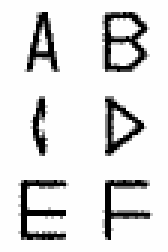

SansSerifFontRL with params:
  0 Height: 0.7645385265350342 (0.6982213854789734)
  1 Slant: 0.8300079107284546 (0.39271318912506104)
  2 Midline: -0.23427248001098633 (0.44169825315475464)
  3 Stroke width: -1.0 (0.07454594224691391)
  4 Bowl curvature: -4.0 (0.01798621006309986)
  5 Width, AV: 0.2017906904220581 (0.5727633237838745)
  6 Width, BPR: 1.0 (0.7445056438446045)
  7 Width, D: 0.587282657623291 (0.6606043577194214)
  8 Width, EF: 0.8815429210662842 (0.7217847108840942)
  9 Width, CGOQ: -0.7336281538009644 (0.35817912220954895)
  10 Width n difference from O, C: 0.8691961765289307 (0.10228922963142395)
  11 Width n difference from E, F: 0.18715929985046387 (0.023326873779296875)
  12 Width p difference from C, G: 0.7388088703155518 (0.08836767077445984)
  13 Offset xp from symmetry, AXZ: 0.13543057441711426 (0.01690298318862915)
  14 Overshoot, AMNVW: 0.4821881055831909 (0.05913221836090088)
  15 Overshoot, CGJOSQ: -0.1411910057067871 (0.0)
  16 Crossbar y offset, A: 0.770885

In [26]:
# learn = None
learner = None
gc.collect()

if 'ocr_model' not in locals() or ocr_model is None:
    ocr_model = load_ocr_model(arch=kaggle_cnn_a_with_res, 
                               df=get_combined_az_and_tmnist_df)

cb = DebugCB(vocal=False)
learner, _ = create_vector_learner(cbs=cb,
                                   # folder="results/test_8_whole_alphabet_Adam",
                                   ocr_model=ocr_model,
                                   n_colors_out=1,
                                   normalise=False,
                                   lr=1e-2, 
                                   debug=False,
                                   init_range=1., # Use smaller range to get values closer to mean
                                   seed=42)

learner.set_param("Aperture, CGS", 0.)
learner.set_param("Termination angle deviation, CGJS", .5)
learner.set_param("Bowl aspect ratio, BPR", 0.)
learner.set_param("Stroke width", -1.)
learner.set_param("Width, BPR", 1.)
learner.set_param("Bowl curvature", -4.)

with debug(learner.model, False):
    display(image_grid([learner.render_letter(l, scale=3) for l in "ABCDEF"]))

learner.model

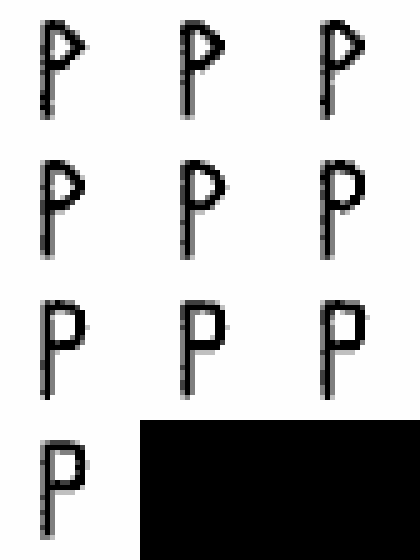

In [114]:
aifont/models/kaggle_cnn_a_with_res__get_combined_az_and_tmnist_df__vocab_437bba8e0bf58337674f4539e75186ac.pth

n = 10
imgs = []
for i in range(n):
    v = -4. + i * 8. / (n - 1)
    learner.set_param("Bowl curvature", v)
    imgs.append(learner.render_letter("B", scale=5))
image_grid(imgs)

In [93]:
learner.model

SansSerifFontRL with params:
  0 Height: 0.7645385265350342 (0.6982213854789734)
  1 Slant: 0.8300079107284546 (0.39271318912506104)
  2 Midline: -0.23427248001098633 (0.44169825315475464)
  3 Bowl curvature: 4.0 (0.9820137619972229)
  4 Width, AV: -0.21910357475280762 (0.47317007184028625)
  5 Width, BPR: 0.2017906904220581 (0.5727633237838745)
  6 Offset xp from symmetry, AXZ: -0.48685503005981445 (-0.059682637453079224)
  7 Overshoot, AMNVW: 0.587282657623291 (0.07137072086334229)
  8 Crossbar y offset, A: 0.8815429210662842 (0.20714181661605835)
  9 Bowl aspect ratio, BPR: -0.7336281538009644 (0.6487981081008911)
  10 Bowl distortion, BPR: 0.8691961765289307 (0.7045784592628479)
  11 Crossbar y offset, B: 0.18715929985046387 (0.04665374755859375)
  12 Upper bowl xn offset, B: 0.7388088703155518 (0.08836767077445984)
  13 Stroke width: 0.13543057441711426 (0.13811343908309937)

## Export

In [5]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_fontsampler.ipynb.
Converted 02_ocrlearner.ipynb.
Converted 03_fontlearner.ipynb.
Converted index.ipynb.
